In [1]:
import numpy as np
import pandas
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import datetime
from scipy.stats import mode

In [2]:
# 2022 시작일 때 f1 score가 모두 0.62로 높음

start = "2017-01-01"
today = str(datetime.date.today()-datetime.timedelta(1))
df = web.DataReader("SPY", data_source="yahoo", start=start, end=today)[["Open", "High", "Low", "Close"]]
df.dropna()

,Open,High,Low,Close
Date,,,,
2017-01-03,225.039993,225.830002,223.880005,225.240005
2017-01-04,225.619995,226.750000,225.610001,226.580002
2017-01-05,226.270004,226.580002,225.479996,226.399994
2017-01-06,226.529999,227.750000,225.899994,227.210007
2017-01-09,226.910004,227.070007,226.419998,226.460007
...,...,...,...,...
2022-05-02,412.070007,415.920013,405.019989,414.480011
2022-05-03,415.010010,418.929993,413.359985,416.380005
2022-05-04,417.079987,429.660004,413.709991,429.059998


In [3]:
# data preprocessing

def get_MACD(df, short=12, long=26, signal=9):
    df["MACD"] = df["Close"].ewm(span=short, min_periods=short-1, adjust=False).mean() - df["Close"].ewm(span=long, min_periods=long-1, adjust=False).mean()
    return df

df["MA10"] = df["Close"].rolling(window=10).mean()
df["Corr"] = df["Close"].rolling(window=10).corr(df["MA10"])
df["Open-Close"] = df["Open"]-df["Close"].shift(1)
df["Open-Open"] = df["Open"]-df["Open"].shift(1)
df = get_MACD(df)
df = df.dropna()

X0 = df[["Open", "Close"]]
X1 = df[["Open", "Close", "Open-Close"]]
X2 = df[["Open", "Close", "Open-Close", "Open-Open"]]
X3 = df[["Open", "Close", "Open-Close", "Open-Open", "MACD", "MA10"]]
X4 = df[["Open", "High", "Low", "Close", "Open-Close", "Open-Open", "MA10", "Corr", "MACD"]]

y = np.where(df["Close"].shift(-1) > df["Close"], 1, 0)

train_pct = 0.8
split = int(train_pct*len(df))

X0_train, X0_test = X0[:split], X0[split:]
X1_train, X1_test = X1[:split], X1[split:]
X2_train, X2_test = X2[:split], X2[split:]
X3_train, X3_test = X3[:split], X3[split:]
X4_train, X4_test = X4[:split], X4[split:]

y_train, y_test =  y[:split], y[split:]

In [4]:
def train_pred(model, dataset):
    model = sklearn.base.clone(model)  # 깊은 복사. 이거 안하면 오브젝트 하나를 계속 학습시키게 됨
    model.fit(dataset[0], dataset[1])
    score = model.score(dataset[2], dataset[3])
    print(score)
    return model, score

models = [LogisticRegression(), RandomForestClassifier(), XGBClassifier(use_label_encoder=False), SGDClassifier(loss="hinge", penalty="l2"), SVC()]
datasets = [
    [X0_train, y_train, X0_test, y_test],
    [X1_train, y_train, X1_test, y_test],
    [X2_train, y_train, X2_test, y_test],
    [X3_train, y_train, X3_test, y_test],
    [X4_train, y_train, X4_test, y_test]
]

# train, scoring
scores = []
trained_models = {}
for model_index in range(len(models)):
    for dataset_index in range(len(datasets)):
        print(f"model-{model_index} dataset-{dataset_index}==============")
        model, score = train_pred(models[model_index], datasets[dataset_index])
        scores.append([f"model-{model_index} dataset-{dataset_index}", score])
        trained_models[f"model-{model_index} dataset-{dataset_index}"] = model

model-0 dataset-0==============
0.5245283018867924
model-0 dataset-1==============
0.5320754716981132
model-0 dataset-2==============
0.5433962264150943
model-0 dataset-3==============
0.539622641509434
model-0 dataset-4==============


C:\Users\isyslab\anaconda3\envs\data\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.539622641509434
model-1 dataset-0==============
0.47547169811320755
model-1 dataset-1==============
0.4716981132075472
model-1 dataset-2==============
0.5358490566037736
model-1 dataset-3==============
0.5735849056603773
model-1 dataset-4==============
0.5735849056603773
model-2 dataset-0==============
[01:09:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.47547169811320755
model-2 dataset-1==============
[01:09:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.49056603773584906
mo

In [5]:
top_score = max(scores, key=lambda x: x[1])
top_score

['model-1 dataset-3', 0.5735849056603773]

In [6]:
preds = []
for i, model in enumerate(trained_models):
    pred = trained_models[model].predict(datasets[i%5][2])
    preds.append(pred)

preds = np.array(preds)
preds.shape

(25, 265)

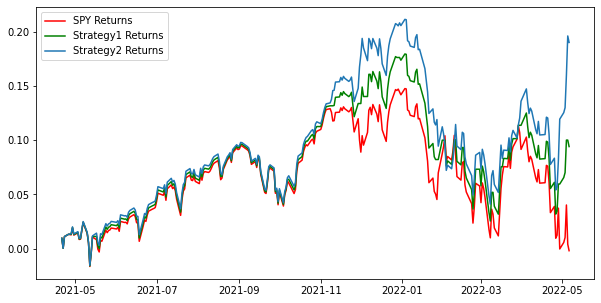

In [7]:
# 매매 실행

df["Signal1"] = np.concatenate((np.ones(len(X0_train)), mode(preds)[0][0]), axis=0)
df["Signal2"] = df["Signal1"].replace(0, -1)  # 하락이 예상될 때 공매도를 치는 전략

df["SPY_Returns"] = np.log(df["Close"] / df["Close"].shift(1))  # SNP 일간수익률
Cum_SPY_Returns = np.cumsum(df[split:]["SPY_Returns"])  # SNP 누적수익률

df["STR1_Returns"] = df["SPY_Returns"] * df["Signal1"].shift(1)
Cum_STR1_Returns = np.cumsum(df[split:]["STR1_Returns"])

df["STR2_Returns"] = df["SPY_Returns"] * df["Signal2"].shift(1)
Cum_STR2_Returns = np.cumsum(df[split:]["STR2_Returns"])

plt.figure(figsize=(10, 5))
plt.plot(Cum_SPY_Returns, color='r', label="SPY Returns")
plt.plot(Cum_STR1_Returns, color='g', label="Strategy1 Returns")
plt.plot(Cum_STR2_Returns, label="Strategy2 Returns")
plt.legend()
plt.show()

In [8]:
# 샤프비율 계산
Std1= Cum_STR1_Returns.std()
Sharpe1 = (Cum_STR1_Returns - Cum_SPY_Returns)/Std1
Sharpe1 = Sharpe1.mean()
print("Sharpe1 ratio :", Sharpe1)

Std2= Cum_STR2_Returns.std()
Sharpe2 = (Cum_STR2_Returns - Cum_SPY_Returns)/Std2
Sharpe2 = Sharpe2.mean()
print("Sharpe2 ratio :", Sharpe2)

Sharpe1 ratio : 0.26688840390056134
Sharpe2 ratio : 0.4432173790318648


In [9]:
predicted1 = mode(preds)[0][0]
print("confusion matrix==========================")
print(metrics.confusion_matrix(y_test, predicted1))
print("classification report==========================")
print(metrics.classification_report(y_test, predicted1))

confusion matrix==========================
[[ 18 106]
 [ 11 130]]
classification report==========================
              precision    recall  f1-score   support

           0       0.62      0.15      0.24       124
           1       0.55      0.92      0.69       141

    accuracy                           0.56       265
   macro avg       0.59      0.53      0.46       265
weighted avg       0.58      0.56      0.48       265

